In [1]:
# import required libraries:
import pandas as pd 
import numpy as np 
import  matplotlib.pyplot as plt
import seaborn as sns

import spacy
import re
import string
import nltk
import pickle
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from nltk.stem.snowball import SnowballStemmer
nlp = spacy.load("en_core_web_sm")

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_auc_score , accuracy_score , confusion_matrix , f1_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# loading the dataset
df= pd.read_csv(r"C:\Users\ANBU NAMBI\Desktop\E IV  Text Analytics\fake_new_detection\fake_news_detection.csv")

In [3]:
df.shape # displaying the shape of the data 

(10000, 6)

In [4]:
df=df.drop(['Unnamed: 0'],axis=1) # dropping the unnessary columns 

In [5]:
df.head() # displaying the head of the data

,title,text,subject,date,category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


### EDA

In [6]:
df.subject.value_counts()

politicsNews       1500
worldnews          1500
News               1500
politics           1500
left-news          1500
Government News    1500
US_News             500
Middle-east         500
Name: subject, dtype: int64

In [7]:
df.category.value_counts()

0    7000
1    3000
Name: category, dtype: int64

D:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='category', ylabel='count'>

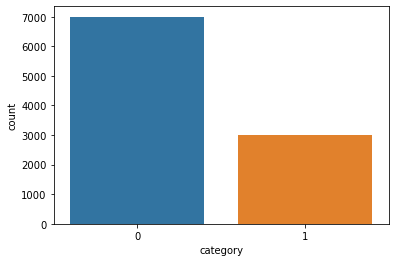

In [8]:
sns.countplot(df.category)

[Text(0, 0, 'politicsNews'),
 Text(1, 0, 'worldnews'),
 Text(2, 0, 'News'),
 Text(3, 0, 'politics'),
 Text(4, 0, 'left-news'),
 Text(5, 0, 'Government News'),
 Text(6, 0, 'US_News'),
 Text(7, 0, 'Middle-east')]

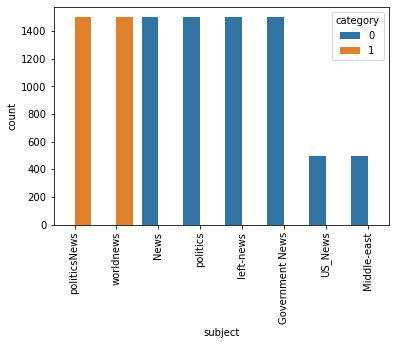

In [9]:
chart = sns.countplot(x = "subject", hue = "category" , data = df)
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

In [10]:
df['text'] = df['text'] + " " + df['title'] # concating the text and the title column

In [11]:
df['text']

0       WASHINGTON (Reuters) - The head of a conservat...
1       WASHINGTON (Reuters) - Transgender people will...
2       WASHINGTON (Reuters) - The special counsel inv...
3       WASHINGTON (Reuters) - Trump campaign adviser ...
4       SEATTLE/WASHINGTON (Reuters) - President Donal...
                              ...                        
9995    21st Century WireAccording to reports, the FBI...
9996    Brasscheck TVA lot of people are going to vote...
9997    21st Century Wire asks . HAVE YOUR SHOUT: Whic...
9998    21st Century Wire Yesterday, Judge Anna Brown ...
9999    21st Century Wire says 21WIRE reported on Frid...
Name: text, Length: 10000, dtype: object

In [12]:
df=df.drop(['title','subject','date'],axis=1) # dropping the unnessary columns 

In [13]:
df

,text,category
0,WASHINGTON (Reuters) - The head of a conservat...,1
1,WASHINGTON (Reuters) - Transgender people will...,1
2,WASHINGTON (Reuters) - The special counsel inv...,1
3,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,1
...,...,...
9995,"21st Century WireAccording to reports, the FBI...",0
9996,Brasscheck TVA lot of people are going to vote...,0
9997,21st Century Wire asks . HAVE YOUR SHOUT: Whic...,0
9998,"21st Century Wire Yesterday, Judge Anna Brown ...",0


In [14]:
# regular expression
def clean_text(text):
    text =  text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"\r", "", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", text)
    text = re.sub("(\\W)"," ",text) 
    text = re.sub('\S*\d\S*\s*','', text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [15]:
df.text = df.text.apply(clean_text)
df.head(10)

,text,category
0,washington reuters the head of a conservative...,1
1,washington reuters transgender people will be...,1
2,washington reuters the special counsel invest...,1
3,washington reuters trump campaign adviser geo...,1
4,seattlewashington reuters president donald tr...,1
5,west palm beach flawashington reuters the whi...,1
6,west palm beach fla reuters president donald ...,1
7,the following statements were posted to the ve...,1
8,the following statements were posted to the ve...,1
9,washington reuters alabama secretary of state...,1


In [16]:
text_data = df['text']
text_data = pd.DataFrame(text_data)
text_data

,text
0,washington reuters the head of a conservative...
1,washington reuters transgender people will be...
2,washington reuters the special counsel invest...
3,washington reuters trump campaign adviser geo...
4,seattlewashington reuters president donald tr...
...,...
9995,century wireaccording to reports the fbi have ...
9996,brasscheck tva lot of people are going to vote...
9997,century wire asks have your shout which us ol...
9998,century wire yesterday judge anna brown handed...


In [17]:
#Punctuation removal
#Stop words removal
#Lemmatization of the words
def process(text_data):
    strs=[]
    for j in text_data.text:
        doc = nlp(j)
        l=[]
        s=""
        for i in doc:
            if not (i.pos_=="PUNCT"):
                if not nlp.vocab[i.text].is_stop:
                    l.append(i.lemma_) 
                    s="{0} {1}".format(s,i.lemma_)

        strs=strs+[s]

    return strs

In [18]:
lem = process(text_data)
text_data.text = lem
text_data.text

0        washington reuters   head conservative republ...
1        washington reuters   transgender people allow...
2        washington reuters   special counsel investig...
3        washington reuters   trump campaign adviser g...
4        seattlewashington reuters   president donald ...
                              ...                        
9995     century wireaccorde report fbi obtain warrant...
9996     brasscheck tva lot people go vote donald trum...
9997     century wire ask   shout oligarch family corr...
9998     century wire yesterday judge anna brown hand ...
9999     century wire say report friday fbi s surprisi...
Name: text, Length: 10000, dtype: object

In [19]:
lem

[' washington reuters   head conservative republican faction congress vote month huge expansion national debt pay tax cut call   fiscal conservative   sunday urge budget restraint keep sharp pivot way republicans representative mark meadow speak cbs    face nation   draw hard line federal spending lawmaker brace battle january return holiday wednesday lawmaker begin try pass federal budget fight likely link issue immigration policy november congressional election campaign approach republican seek control congress president donald trump republican want big budget increase military spending democrats want proportional increase nondefense   discretionary   spending program support education scientific research infrastructure public health environmental protection   trump administration willing   go increase nondefense discretionary spending   percent    meadow chairman small influential house freedom caucus say program   democrats say s need government pay raise percent fiscal conservativ

In [20]:
def plot_word_cloud(pos_lst,neg_lst):
    _,ax = plt.subplots(1,2,figsize=(50,50))
    wordcloud = WordCloud(width = 400, height = 400,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate_from_frequencies(pos_lst)
 
    ax[0].imshow(wordcloud)
    ax[0].axis("off")
    
    wordcloud = WordCloud(width = 400, height = 400,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate_from_frequencies(neg_lst)
 
    ax[1].imshow(wordcloud)
    ax[1].axis("off")
    plt.show()

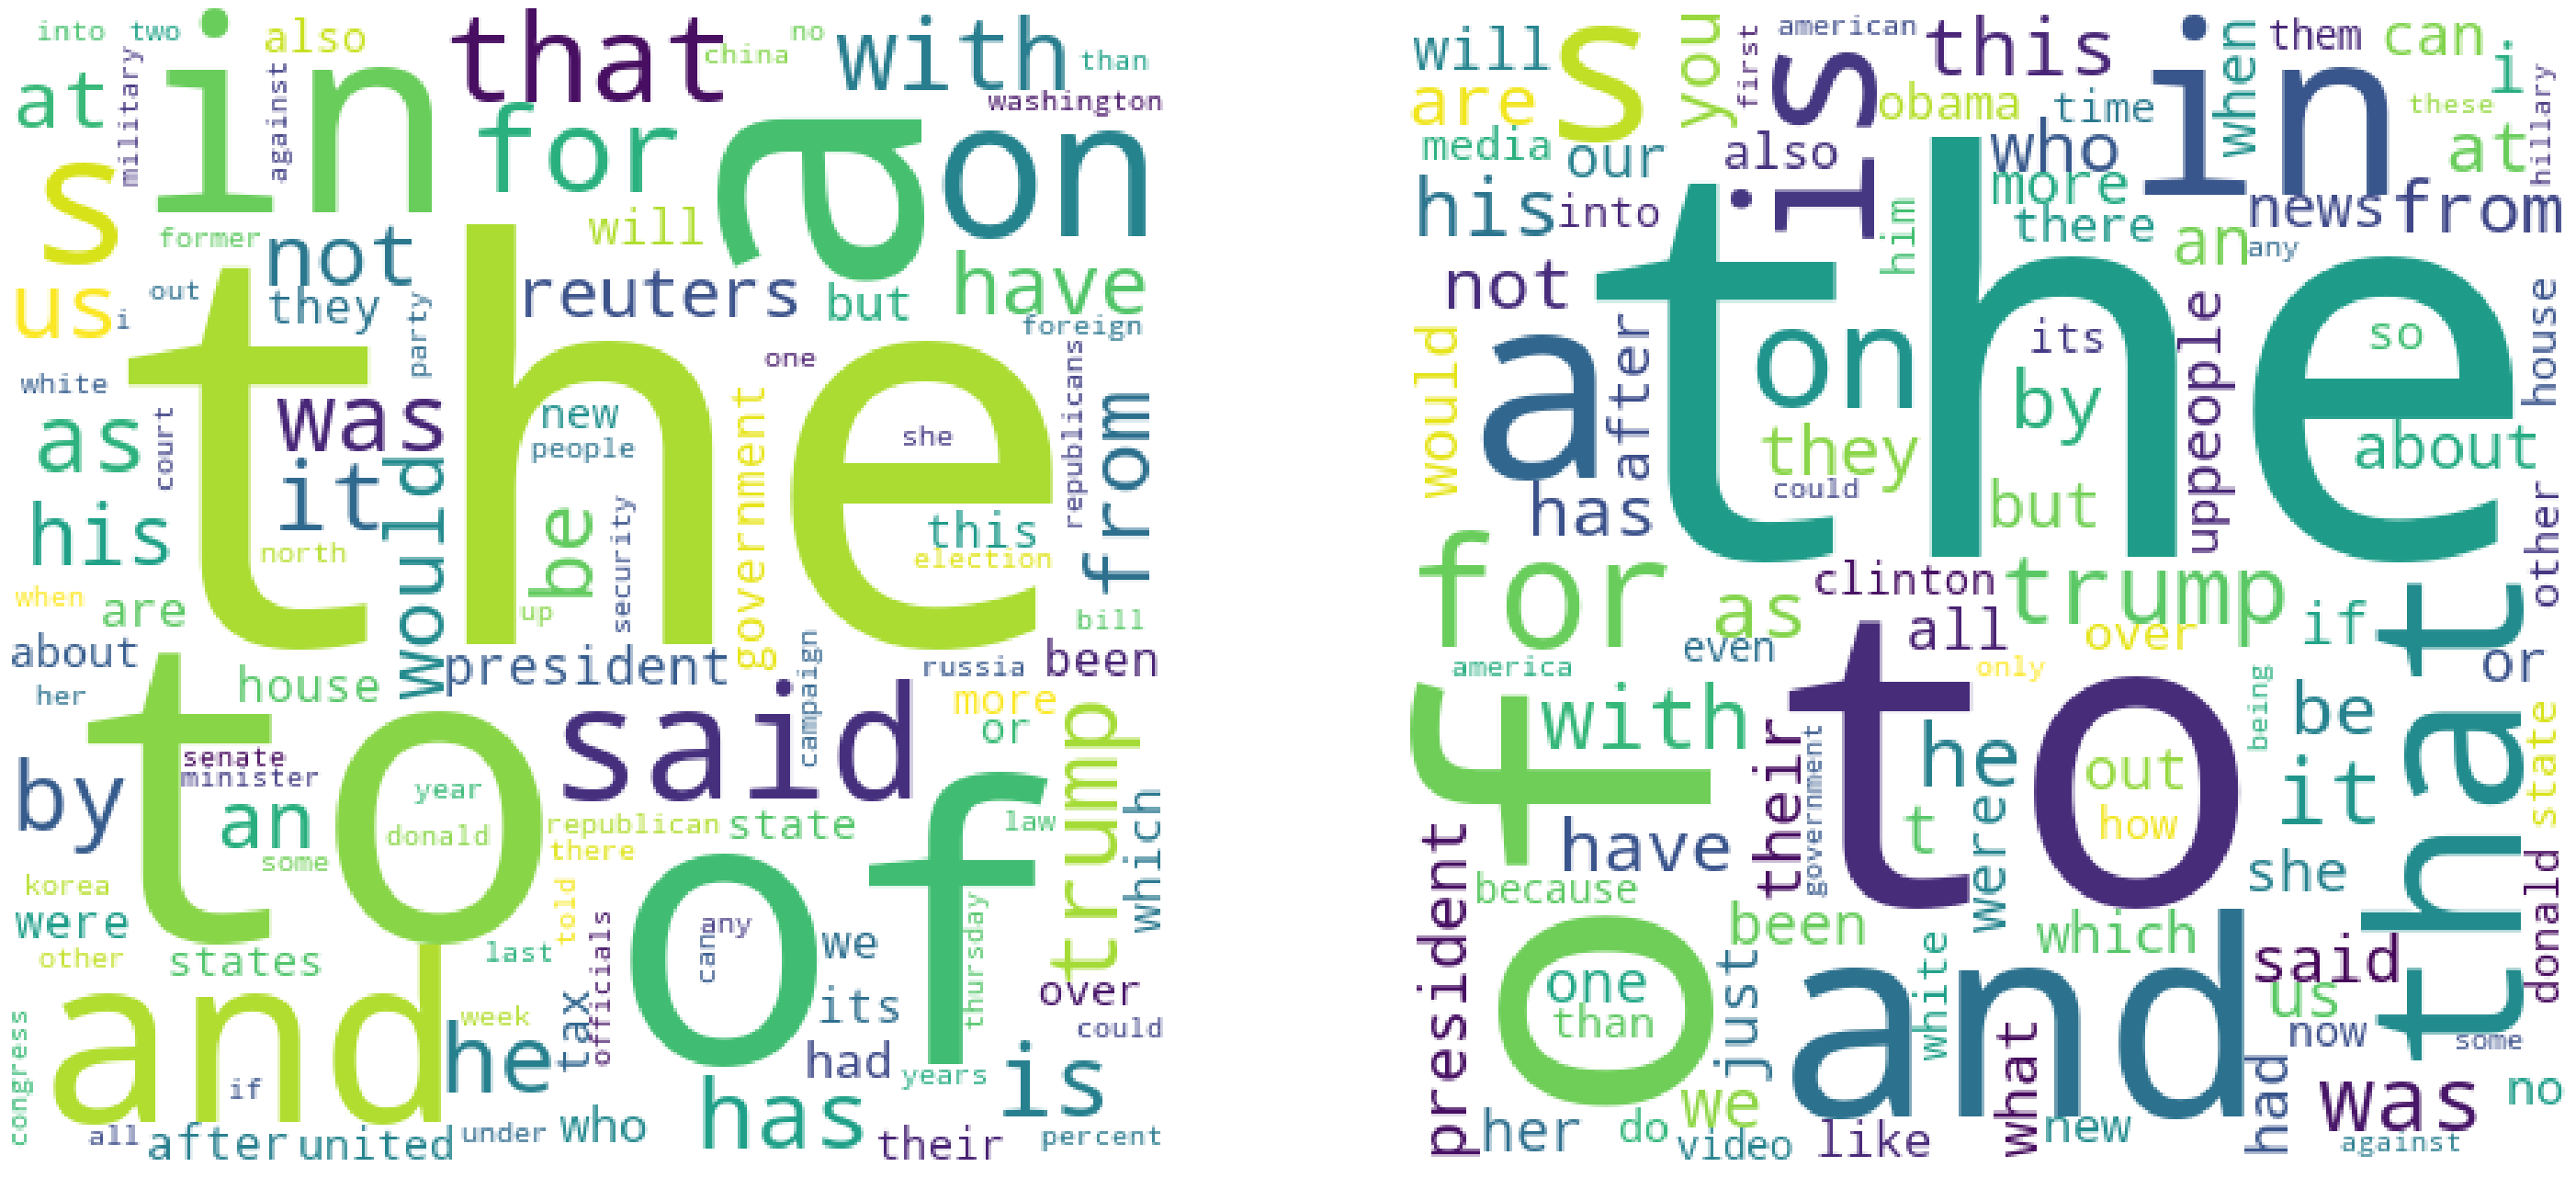

In [21]:
plot_word_cloud(FreqDist(nltk.word_tokenize(' '.join(df[df["category"]==1]["text"]))),
    FreqDist(nltk.word_tokenize(' '.join(df[df["category"]==0]["text"]))))

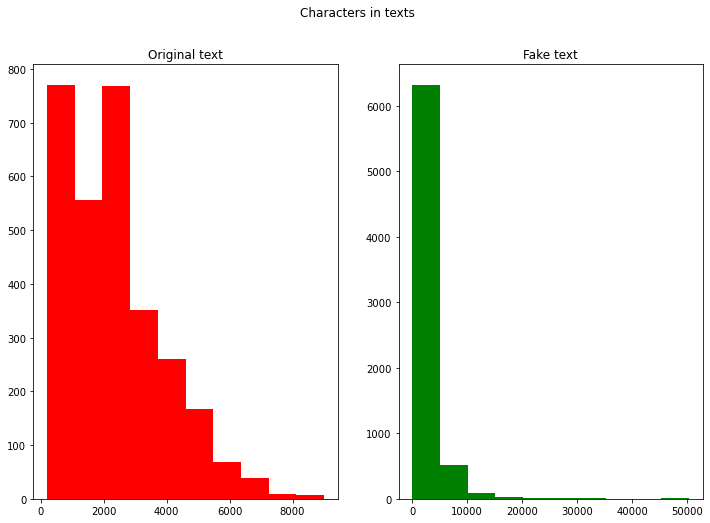

In [22]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df[df['category']==1]['text'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Original text')
text_len=df[df['category']==0]['text'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Fake text')
fig.suptitle('Characters in texts')
plt.show()

In [23]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.text)
corpus[:5]

['washington', 'reuters', 'the', 'head', 'of']

In [24]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'the': 256538,
 'to': 133660,
 'of': 112927,
 'and': 102401,
 'a': 98136,
 'in': 84350,
 'that': 60242,
 's': 59202,
 'on': 45415,
 'for': 43863}

In [25]:
x =  text_data.text
y =  df["category"]

In [26]:
text_data

,text
0,washington reuters head conservative republ...
1,washington reuters transgender people allow...
2,washington reuters special counsel investig...
3,washington reuters trump campaign adviser g...
4,seattlewashington reuters president donald ...
...,...
9995,century wireaccorde report fbi obtain warrant...
9996,brasscheck tva lot people go vote donald trum...
9997,century wire ask shout oligarch family corr...
9998,century wire yesterday judge anna brown hand ...


In [27]:
x_train,x_test,y_train,y_test =  train_test_split(x,y,test_size = 0.2,random_state = 45)

In [28]:
y_train.head()

4643    0
2390    1
6162    0
8678    0
6944    0
Name: category, dtype: int64

In [29]:
word_vectorizer = TfidfVectorizer(
    strip_accents='unicode',     
    analyzer='word',            
    token_pattern=r'\w{1,}',    
    ngram_range=(1, 3),         
    stop_words='english',
    sublinear_tf=True)

word_vectorizer.fit(x_train)    
train_word_features = word_vectorizer.transform(x_train)

In [30]:
X_train_transformed= word_vectorizer.transform(x_train)
X_test_transformed = word_vectorizer.transform(x_test)

In [31]:
print(X_train_transformed)

  (0, 2322790)	0.040318904646297594
  (0, 2322739)	0.05147918098846219
  (0, 2322638)	0.03936333638871024
  (0, 2321618)	0.029060424996139984
  (0, 2315631)	0.05147918098846219
  (0, 2315630)	0.04923336438713767
  (0, 2311463)	0.010647753511161309
  (0, 2306439)	0.05147918098846219
  (0, 2306435)	0.0431482989475443
  (0, 2305087)	0.01635102498945026
  (0, 2271212)	0.05147918098846219
  (0, 2271211)	0.05147918098846219
  (0, 2271178)	0.029436260530962745
  (0, 2249382)	0.05147918098846219
  (0, 2249367)	0.03237016482442636
  (0, 2247470)	0.015358261961170894
  (0, 2244505)	0.05147918098846219
  (0, 2244500)	0.03343302326123633
  (0, 2243871)	0.01285885445349602
  (0, 2208950)	0.05147918098846219
  (0, 2208949)	0.05147918098846219
  (0, 2208074)	0.05147918098846219
  (0, 2208070)	0.045394115548868824
  (0, 2207467)	0.026610579027741884
  (0, 2198319)	0.0431482989475443
  :	:
  (7999, 221239)	0.059291500508284564
  (7999, 221238)	0.059291500508284564
  (7999, 221135)	0.03688985577826618
 

In [32]:
print(X_test_transformed)

  (0, 2320993)	0.08197779462569015
  (0, 2320992)	0.062423265562716185
  (0, 2320675)	0.08239787831832938
  (0, 2292669)	0.06653923226675061
  (0, 2291625)	0.030176067248802386
  (0, 2285186)	0.04014204656100016
  (0, 2267704)	0.057421577835959706
  (0, 2263027)	0.07932459262951899
  (0, 2262320)	0.021295144677278312
  (0, 2254293)	0.07726660927750179
  (0, 2253585)	0.08197779462569015
  (0, 2251966)	0.03739811477855201
  (0, 2248281)	0.0640312724533411
  (0, 2247470)	0.05366745474244634
  (0, 2230338)	0.07416343081993838
  (0, 2230040)	0.038136915433828605
  (0, 2207467)	0.021113431773278405
  (0, 2199386)	0.0576385922719569
  (0, 2198096)	0.02752286525263126
  (0, 2181280)	0.05279658646090525
  (0, 2174941)	0.0536108816289343
  (0, 2172846)	0.0604393604241905
  (0, 2153831)	0.08571727281090322
  (0, 2153176)	0.026720386470582096
  (0, 2139512)	0.06279975408153753
  :	:
  (1999, 213897)	0.033844709741923516
  (1999, 138955)	0.03246858688296217
  (1999, 117803)	0.05130055919361742
  (1

In [33]:
df.category.value_counts(normalize=True)

0    0.7
1    0.3
Name: category, dtype: float64

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

In [35]:
clf = MultinomialNB().fit(X_train_transformed, y_train)
predicted = clf.predict(X_test_transformed)
round(np.mean(predicted == y_test), 4)

0.799

In [36]:
classes = ["Fake news","True news"]
def make_test_predictions(df,classifier):
    df.text = df.text.apply(clean_text)
    df.text = process(df)
    X_test = df.text
    X_test_transformed = word_vectorizer.transform(X_test)
    y_test_pred = clf.predict_proba(X_test_transformed)
    result =  sum(y_test_pred[0])
    if result >=1 :
        res = np.argmax(y_test_pred)
        return(classes[res])
        
    else :
        return ("True news")

In [37]:
text = "WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a â€œfiscal conservativeâ€ on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBSâ€™ â€œFace the Nation,â€ drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-defense â€œdiscretionaryâ€ spending on programs that support education, scientific research, infrastructure, public health and environmental protection. â€œThe (Trump) administration has already been willing to say: â€˜Weâ€™re going to increase non-defense discretionary spending ... by about 7 percent,â€™â€ Meadows, chairman of the small but influential House Freedom Caucus, said on the program. â€œNow, Democrats are saying thatâ€™s not enough, we need to give the government a pay raise of 10 to 11 percent. For a fiscal conservative, I donâ€™t see where the rationale is. ... Eventually you run out of other peopleâ€™s money,â€ he said. Meadows was among Republicans who voted in late December for their partyâ€™s debt-financed tax overhaul, which is expected to balloon the federal budget deficit and add about $1.5 trillion over 10 years to the $20 trillion national debt. â€œItâ€™s interesting to hear Mark talk about fiscal responsibility,â€ Democratic U.S. Representative Joseph Crowley said on CBS. Crowley said the Republican tax bill would require the  United States to borrow $1.5 trillion, to be paid off by future generations, to finance tax cuts for corporations and the rich. â€œThis is one of the least ... fiscally responsible bills weâ€™ve ever seen passed in the history of the House of Representatives. I think weâ€™re going to be paying for this for many, many years to come,â€ Crowley said. Republicans insist the tax package, the biggest U.S. tax overhaul in more than 30 years,  will boost the economy and job growth. House Speaker Paul Ryan, who also supported the tax bill, recently went further than Meadows, making clear in a radio interview that welfare or â€œentitlement reform,â€ as the party often calls it, would be a top Republican priority in 2018. In Republican parlance, â€œentitlementâ€ programs mean food stamps, housing assistance, Medicare and Medicaid health insurance for the elderly, poor and disabled, as well as other programs created by Washington to assist the needy. Democrats seized on Ryanâ€™s early December remarks, saying they showed Republicans would try to pay for their tax overhaul by seeking spending cuts for social programs. But the goals of House Republicans may have to take a back seat to the Senate, where the votes of some Democrats will be needed to approve a budget and prevent a government shutdown. Democrats will use their leverage in the Senate, which Republicans narrowly control, to defend both discretionary non-defense programs and social spending, while tackling the issue of the â€œDreamers,â€ people brought illegally to the country as children. Trump in September put a March 2018 expiration date on the Deferred Action for Childhood Arrivals, or DACA, program, which protects the young immigrants from deportation and provides them with work permits. The president has said in recent Twitter messages he wants funding for his proposed Mexican border wall and other immigration law changes in exchange for agreeing to help the Dreamers. Representative Debbie Dingell told CBS she did not favor linking that issue to other policy objectives, such as wall funding. â€œWe need to do DACA clean,â€ she said.  On Wednesday, Trump aides will meet with congressional leaders to discuss those issues. That will be followed by a weekend of strategy sessions for Trump and Republican leaders on Jan. 6 and 7, the White House said. Trump was also scheduled to meet on Sunday with Florida Republican Governor Rick Scott, who wants more emergency aid. The House has passed an $81 billion aid package after hurricanes in Florida, Texas and Puerto Rico, and wildfires in California. The package far exceeded the $44 billion requested by the Trump administration. The Senate has not yet voted on the aid. "
comment ={'id':[1],'text':[text]}
comment = pd.DataFrame(comment)
res=make_test_predictions(comment,clf)
print(res)

Fake news


In [38]:
text = "Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of decency won t even allow him to rise above the gutter long enough to wish the American citizens a happy new year!  Bishop Talbert Swan (@TalbertSwan) December 31, 2017no one likes you  Calvin (@calvinstowell) December 31, 2017Your impeachment would make 2018 a great year for America, but I ll also accept regaining control of Congress.  Miranda Yaver (@mirandayaver) December 31, 2017Do you hear yourself talk? When you have to include that many people that hate you you have to wonder? Why do the they all hate me?  Alan Sandoval (@AlanSandoval13) December 31, 2017Who uses the word Haters in a New Years wish??  Marlene (@marlene399) December 31, 2017You can t just say happy new year?  Koren pollitt (@Korencarpenter) December 31, 2017Here s Trump s New Year s Eve tweet from 2016.Happy New Year to all, including to my many enemies and those who have fought me and lost so badly they just don t know what to do. Love!  Donald J. Trump (@realDonaldTrump) December 31, 2016This is nothing new for Trump. He s been doing this for years.Trump has directed messages to his  enemies  and  haters  for New Year s, Easter, Thanksgiving, and the anniversary of 9/11. pic.twitter.com/4FPAe2KypA  Daniel Dale (@ddale8) December 31, 2017Trump s holiday tweets are clearly not presidential.How long did he work at Hallmark before becoming President?  Steven Goodine (@SGoodine) December 31, 2017He s always been like this . . . the only difference is that in the last few years, his filter has been breaking down.  Roy Schulze (@thbthttt) December 31, 2017Who, apart from a teenager uses the term haters?  Wendy (@WendyWhistles) December 31, 2017he s a fucking 5 year old  Who Knows (@rainyday80) December 31, 2017So, to all the people who voted for this a hole thinking he would change once he got into power, you were wrong! 70-year-old men don t change and now he s a year older.Photo by Andrew Burton/Getty Images."
comment ={'id':[10],'text':[text]}
comment = pd.DataFrame(comment)
res=make_test_predictions(comment,clf)
print(res)

True news


In [39]:
text = "Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of decency won t even allow him to rise above the gutter long enough to wish the American citizens a happy new year!  Bishop Talbert Swan (@TalbertSwan) December 31, 2017no one likes you  Calvin (@calvinstowell) December 31, 2017Your impeachment would make 2018 a great year for America, but I ll also accept regaining control of Congress.  Miranda Yaver (@mirandayaver) December 31, 2017Do you hear yourself talk? When you have to include that many people that hate you you have to wonder? Why do the they all hate me?  Alan Sandoval (@AlanSandoval13) December 31, 2017Who uses the word Haters in a New Years wish??  Marlene (@marlene399) December 31, 2017You can t just say happy new year?  Koren pollitt (@Korencarpenter) December 31, 2017Here s Trump s New Year s Eve tweet from 2016.Happy New Year to all, including to my many enemies and those who have fought me and lost so badly they just don t know what to do. Love!  Donald J. Trump (@realDonaldTrump) December 31, 2016This is nothing new for Trump. He s been doing this for years.Trump has directed messages to his  enemies  and  haters  for New Year s, Easter, Thanksgiving, and the anniversary of 9/11. pic.twitter.com/4FPAe2KypA  Daniel Dale (@ddale8) December 31, 2017Trump s holiday tweets are clearly not presidential.How long did he work at Hallmark before becoming President?  Steven Goodine (@SGoodine) December 31, 2017He s always been like this . . . the only difference is that in the last few years, his filter has been breaking down.  Roy Schulze (@thbthttt) December 31, 2017Who, apart from a teenager uses the term haters?  Wendy (@WendyWhistles) December 31, 2017he s a fucking 5 year old  Who Knows (@rainyday80) December 31, 2017So, to all the people who voted for this a hole thinking he would change once he got into power, you were wrong! 70-year-old men don t change and now he s a year older.Photo by Andrew Burton/Getty Images."
uniquecount = {}
d=nltk.sent_tokenize(text)
for data in d:
    words = nltk.word_tokenize(data)
    for word in words:
        if word not in uniquecount.keys():
            uniquecount[word] = 1
        else:
            uniquecount[word] += 1

In [40]:
uniquecount

{'Donald': 3,
 'Trump': 6,
 'just': 4,
 'couldn': 2,
 't': 6,
 'wish': 5,
 'all': 6,
 'Americans': 1,
 'a': 14,
 'Happy': 3,
 'New': 8,
 'Year': 7,
 'and': 14,
 'leave': 1,
 'it': 2,
 'at': 2,
 'that': 4,
 '.': 14,
 'Instead': 1,
 ',': 39,
 'he': 6,
 'had': 2,
 'to': 14,
 'give': 1,
 'shout': 1,
 'out': 1,
 'his': 3,
 'enemies': 5,
 'haters': 5,
 'the': 12,
 'very': 3,
 'dishonest': 3,
 'fake': 1,
 'news': 1,
 'media': 1,
 'The': 1,
 'former': 1,
 'reality': 1,
 'show': 1,
 'star': 1,
 'one': 2,
 'job': 1,
 'do': 4,
 'As': 2,
 'our': 2,
 'Country': 2,
 'rapidly': 2,
 'grows': 2,
 'stronger': 2,
 'smarter': 2,
 'I': 3,
 'want': 2,
 'of': 6,
 'my': 3,
 'friends': 2,
 'supporters': 2,
 'even': 3,
 'Fake': 2,
 'News': 2,
 'Media': 2,
 'Healthy': 2,
 'President': 2,
 'Angry': 1,
 'Pants': 1,
 'tweeted': 1,
 '2018': 3,
 'will': 2,
 'be': 2,
 'great': 3,
 'year': 7,
 'for': 7,
 'America': 3,
 '!': 6,
 'J.': 2,
 '(': 13,
 '@': 13,
 'realDonaldTrump': 2,
 ')': 13,
 'December': 13,
 '31': 13,
 '

In [41]:
for k, v in uniquecount.items():
    if v == 1:
        print(k,":",v)

Americans : 1
leave : 1
Instead : 1
give : 1
shout : 1
out : 1
fake : 1
news : 1
media : 1
The : 1
former : 1
reality : 1
show : 1
star : 1
job : 1
Angry : 1
Pants : 1
tweeted : 1
went : 1
about : 1
welll : 1
d : 1
expect.What : 1
kind : 1
president : 1
sends : 1
greeting : 1
despicable : 1
petty : 1
infantile : 1
gibberish : 1
Only : 1
His : 1
lack : 1
decency : 1
won : 1
allow : 1
him : 1
rise : 1
above : 1
gutter : 1
enough : 1
American : 1
citizens : 1
Bishop : 1
Talbert : 1
Swan : 1
TalbertSwan : 1
2017no : 1
likes : 1
Calvin : 1
calvinstowell : 1
2017Your : 1
impeachment : 1
make : 1
but : 1
ll : 1
also : 1
accept : 1
regaining : 1
control : 1
Congress : 1
Miranda : 1
Yaver : 1
mirandayaver : 1
2017Do : 1
hear : 1
yourself : 1
talk : 1
When : 1
include : 1
wonder : 1
Why : 1
Alan : 1
Sandoval : 1
AlanSandoval13 : 1
word : 1
Haters : 1
Years : 1
Marlene : 1
marlene399 : 1
2017You : 1
can : 1
say : 1
Koren : 1
pollitt : 1
Korencarpenter : 1
2017Here : 1
Eve : 1
2016.Happy : 1
inclu